In [1]:
from IPython.display import Video
from IPython.display import HTML
import jax
import jax.numpy as jnp
import numpy as np
import scipy
import matplotlib.pyplot as plt
from celluloid import Camera

##### Machine Learning and Applications - Linear Models

### David Picard 
### École des Ponts ParisTech
### david.picard@enpc.fr

# Linear Regression
## Scalar input, scalar output

- Input space: $x \in \mathbb{R}$
- Output space: $y \in \mathbb{R}$
- Linear model: $f(x) = ax$

$$ \min_{a} \mathbb{E}_x [ (y - ax)^2 ]$$

Training set $\mathcal{A} = \{(x_i, y_i)\}_{i\leq n}$, minimize the empirical risk

$$ \min_a \frac{1}{n}\sum_i (y_i - ax_i)^2$$

Closed form solution:
- vectorize: $\mathbf{x} = [x_i]$, $\mathbf{y} = [y_i]$
$$ \min_a \frac{1}{n} \| \mathbf{y} - a\mathbf{x} \|^2 $$
- Stationary condition
$$ \frac{\partial}{\partial a}  \frac{1}{n}\| \mathbf{y} - a\mathbf{x} \|^2 = 0 = 2a \|\mathbf{x}\|^2 - 2 \langle \mathbf{y}, \mathbf{x} \rangle$$
$$ a = \frac{\mathbf{y}^\top\mathbf{x}}{\|\mathbf{x}\|^2}$$

## Linear regression - Vector input, scalar output

- Input space: $\mathbf{x} \in \mathbb{R}^d$
- Output space: $y \in \mathbb{R}$
- Linear model: $f(x) = \mathbf{a}^\top\mathbf{x}$

$$ \min_{\mathbf{a}} \mathbb{E}_x [ (y - \mathbf{a}^\top\mathbf{x})^2 ]$$


Training set $\mathcal{A} = \{(\mathbf{x}_i, y_i)\}_{i\leq n}$, minimize the empirical risk

$$ \min_a \frac{1}{n}\sum_i (y_i - \mathbf{a}^\top\mathbf{x}_i)^2$$


Closed form solution
- Matrix form: $\mathbf{X} = [\mathbf{x}_i]$, $\mathbf{y} = [y_i]$

$$ \min_\mathbf{a} \frac{1}{n} \|\mathbf{y} - \mathbf{X}^\top\mathbf{a} \|^2$$

- Stationary condition

$$\frac{\partial}{\partial \mathbf{a}} \frac{1}{n} \|\mathbf{y} - \mathbf{X}^\top\mathbf{a} \|^2 = 0 = 2\mathbf{X}^\top\mathbf{y} + 2\mathbf{XX}^\top\mathbf{a} $$

$$ \mathbf{a} = (\mathbf{XX}^\top)^{-1} \mathbf{X}^\top\mathbf{y} $$

Pseudo-inverse

## Vector input, bis

- SVD: $\mathbf{X} = \mathbf{USV}^\top$

$$ \mathbf{y} = \mathbf{VSU}^\top\mathbf{a} $$
$$ \mathbf{a} = \mathbf{US}^{-1}\mathbf{V}^\top\mathbf{y}$$

Easy solution by projecting into the eigen space of $\mathbf{X}$, $\mathbf{a}$ is in the eigenspace of $\mathbf{X}$

## Karhunen-Loève theorem

Let $\mathbf{x}$ be a stochastic process with covariance matrix $\sum_\mathbf{x}$ then

$$ \mathbf{x}_i = \sum_k^p z_{k,i}\mathbf{e}_k $$

with $\mathbf{e_k}$ the eigenvectors of $\sum_\mathbf{x}$.

- Samples $\mathbf{x}_i$ exist in the space spaned by the eigenvectors of the covariance matrix (hence PCA)
- if $span(\mathbf{x}) < d$, some dimensions are useless (noisy)
- Strong influence on the pseudo-inverse solution ($\mathbf{S}^{-1}$) $\Rightarrow$ remove directions with small eigenvalues

In [2]:
key = jax.random.PRNGKey(0)
key, skey = jax.random.split(key)
x = jax.random.uniform(skey, (50, 1))
X = jnp.concatenate((x, -5*x), axis=1)
a = jnp.array([2, 0])
y = jnp.matmul(X, a)

U, S, V = jnp.linalg.svd(X.T, full_matrices=False)
print('eigenvalues: {}'.format(S))
Vty = jnp.matmul(V, y)
SinvVty = jnp.matmul(jnp.diag(1./S), Vty)
a_hat = jnp.matmul(U, SinvVty)
print('a_hat: {} a: {}'.format(a_hat, a))

eigenvalues: [2.0413006e+01 3.0459864e-07]
a_hat: [-2.8013153  -0.96026266] a: [2 0]


## Linear regression, bias case

Adding a constant to the model is equivalent to the vector case



$$ \min_{\mathbf{a}, b} \frac{1}{n} \|\mathbf{y} - \mathbf{X}^\top\mathbf{a} - \mathbf{1}^\top b \|^2$$

- concatenate $b$ to $\mathbf{a}$ and $1$ to $\mathbf{X}$

$$ \min_{\mathbf{a}, b} \frac{1}{n} \|\mathbf{y} - [\mathbf{X}; \mathbf{1}]^\top[\mathbf{a}; b] \|^2$$

## Linear Regression, Vector input, vector output


- Input space: $\mathbf{x} \in \mathbb{R}^d$
- Output space: $\mathbf{y} \in \mathbb{R}^p$
- Linear model: $f(x) = \mathbf{A}^\top\mathbf{x}$

$$ \min_{\mathbf{a}} \mathbb{E}_x [ \|\mathbf{y} - \mathbf{A}^\top\mathbf{x}\|^2 ]$$


Training set $\mathcal{A} = \{(\mathbf{x}_i, \mathbf{y}_i)\}_{i\leq n}$, minimize the empirical risk

$$ \min_a \frac{1}{n}\sum_i \|\mathbf{y}_i - \mathbf{A}^\top\mathbf{x}_i\|^2$$

Equivalent to $p$ scalar output cases stacked together

## Let's try with MNIST

Regress 0 and 1

0


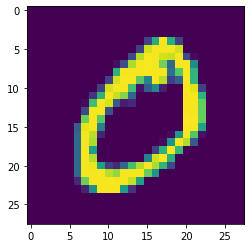

In [3]:
data = np.load('mnist.npz')
X = data['X_train_bin']
y = data['y_train_bin']
plt.imshow(X[0,:].reshape(28,28))
print(y[0])

eigenvalues: [36.45615   17.209862  12.030047  11.947479   9.36883    7.8752723
  6.7997932  6.3316774  5.729243   5.4004116  5.1866603  4.988159
  4.8420706  4.1217637  3.9173453  3.5896347  3.2801106  3.1127822
  3.0160408  2.7964358  2.6677098  2.543037   2.2888196  2.1948047
  2.14488    1.8337901  1.0252038]


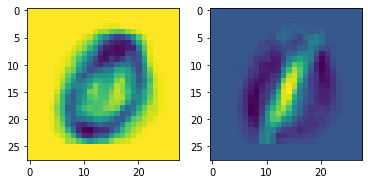

In [4]:
U, S, V = jnp.linalg.svd(X.T, full_matrices=False)
print('eigenvalues: {}'.format(S))
plt.subplot(1,2,1)
plt.imshow(U[:,0].reshape((28,28)))
plt.subplot(1,2,2)
plt.imshow(U[:,1].reshape((28,28)))


If we interpret our predictor as an image, positive pixels tend to push the prediction towards class 1, whereas negative pixels tend to push the prediction toward class 0. Let us display the images of pixels of the same sign.

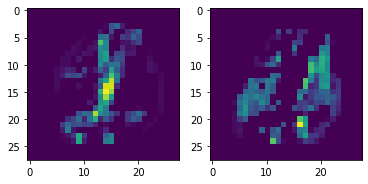

In [5]:
Vty = jnp.matmul(V, y)
SinvVty = jnp.matmul(jnp.diag(1./S), Vty)
a_hat = jnp.matmul(U, SinvVty)

plt.subplot(1,2,1)
plt.imshow(jnp.maximum(a_hat, 0).reshape((28, 28)))
plt.subplot(1,2,2)
plt.imshow(jnp.maximum(-a_hat, 0).reshape((28, 28)))

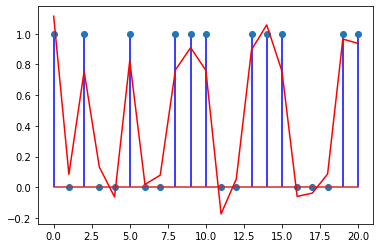

In [6]:
X_val = data['X_val_bin']
y_val = data['y_val_bin']
y_hat = jnp.matmul(X_val, a_hat)
plt.stem(range(len(y_val)), y_val, '-b')
plt.plot(range(len(y_val)), y_hat, '-r')

## MNIST, regress 0-9

eigenvalues: [61.84758  22.601597 19.816174 18.98699  17.21556  15.531815 14.318835
 13.584824 12.348789 11.739741]


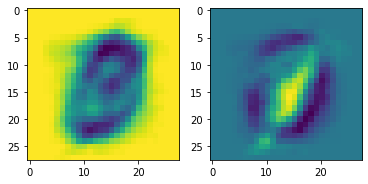

In [7]:
X = data['X_train']
y = data['y_train']

U, S, V = jnp.linalg.svd(X.T, full_matrices=False)
print('eigenvalues: {}'.format(S[0:10]))
plt.subplot(1,2,1)
plt.imshow(U[:,0].reshape((28,28)))
plt.subplot(1,2,2)
plt.imshow(U[:,1].reshape((28,28)))

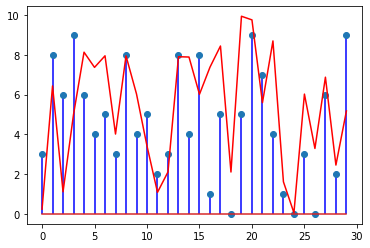

In [8]:
Vty = jnp.matmul(V, y)
SinvVty = jnp.matmul(jnp.diag(1./S), Vty)
a_hat = jnp.matmul(U, SinvVty)

X_val = data['X_val'][0:30,...]
y_val = data['y_val'][0:30]
y_hat = jnp.matmul(X_val, a_hat)
plt.stem(range(len(y_val)), y_val, '-b')
plt.plot(range(len(y_val)), y_hat, '-r')

Output space not adapted (artificial topology)

## MNIST regress 0-9 as one-hot
- Exercise: train a linear regression for each class (one versus all)

In [ ]:
y = jax.nn.one_hot(y, 10)

a = []
for k in range(10):
    #
    #
    a_k = jnp.zeros(784)
    a.append(a_k)
a = jnp.array(a)

y_hat = jnp.argmax(jnp.matmul(X_val, a.T), axis=1)
plt.stem(range(len(y_val)), y_val, '-b')
plt.plot(range(len(y_val)), y_hat, '-r')

# Non-linear case
## Polynomial regression
What if the relation between $x$ and $y$ is not linear?

- Map $\phi: x \mapsto [x, x^2, x^3, \dots, x^p]$

$$ \min_\mathbf{a} \mathbb{E}_x[(y - \phi(x)^\top\mathbf{a})^2]$$

In [10]:
a = [-0.2, 0.7, 0.83, -1.5, 5.23]
p = np.poly1d(a)
x = np.random.rand(24)*4-2
y = p(x) + 0.2*np.random.randn(24)

[ 5.2697163  -1.5135039   0.7879974   0.70156187 -0.19815296]


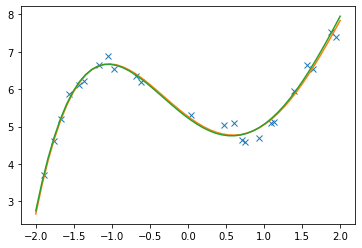

In [11]:
X = jnp.stack([jnp.ones((len(x))), x, x**2, x**3, x**4], axis=1)
U, S, V = jnp.linalg.svd(X.T, full_matrices=False)
Vty = jnp.matmul(V, y)
SinvVty = jnp.matmul(jnp.diag(1./S), Vty)
a_hat = jnp.matmul(U, SinvVty)
print(a_hat)
pp = np.poly1d(a_hat[::-1])

t = np.linspace(-2, 2, 50)
plt.plot(x, y, 'x')
plt.plot(t, pp(t))
plt.plot(t, p(t))

## Periodic signals

Map $\phi: x \mapsto [\sin(f_0 x), \sin(2f_0x), \dots, \sin(pf_0x)]$

In [12]:
a = np.array([0.7, 0.83, -1.5])
x = np.random.rand(48)*16-8
X = jnp.array([ jnp.sin(x), jnp.sin(2*x), jnp.sin(3*x)])
y = jnp.matmul(a, X) + 0.3*np.random.randn(48)

In [13]:
X = jnp.array([jnp.sin(x), jnp.sin(2*x), jnp.sin(3*x)])
ap = jnp.matmul(jnp.matmul(jnp.linalg.inv(jnp.matmul(X, X.transpose())), X), y)
Yp = jnp.matmul(ap, X)

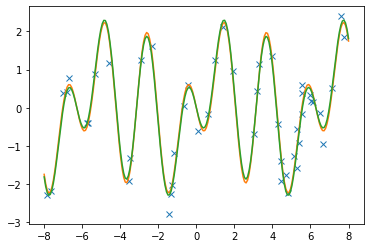

In [14]:
t = np.linspace(-8, 8, 200)
T = np.array([np.sin(t), np.sin(2*t), np.sin(3*t)])
plt.plot(x, y, 'x')
plt.plot(t, np.matmul(ap, T))
plt.plot(t, np.matmul(a, T))

## Overcomplete models

What if $p < \hat{p}$ (model has greater capacity than data)

In [15]:
def sin_approx(x, y, p):
    Xp = jnp.sin(jnp.matmul(x.reshape(-1, 1), 1+jnp.arange(p).reshape(1,p))).transpose()
    ap = jnp.matmul(jnp.matmul(jnp.linalg.inv(jnp.matmul(Xp, Xp.transpose())), Xp), y)
    Yp = jnp.matmul(ap, Xp)
    return ap, Xp, Yp

In [16]:
p = 3
ap, Xp, Yp = sin_approx(x, y, p)
print(a, ap)

[ 0.7   0.83 -1.5 ] [ 0.59392786  0.83312976 -1.5430541 ]


MSE: 0.09781882911920547


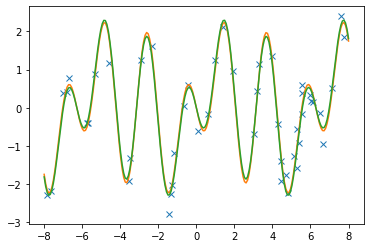

In [17]:
t = jnp.linspace(-8, 8, 200)
T = jnp.sin(np.matmul(t.reshape(-1, 1), 1+jnp.arange(p).reshape(1,p))).transpose()
plt.plot(x, y, 'x')
plt.plot(t, jnp.matmul(ap, T[:len(ap), :]))
plt.plot(t, jnp.matmul(a, T[:len(a), :]))
print('MSE: {}'.format(((y - Yp)**2).mean()))

In [18]:
p = 5
ap, Xp, Yp = sin_approx(x, y, p)
print(a, ap)

[ 0.7   0.83 -1.5 ] [ 0.59637094  0.8385289  -1.5672264   0.06469631 -0.01800793]


MSE: 0.0961289182305336


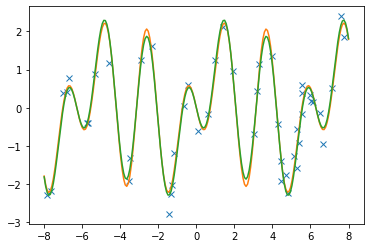

In [19]:
t = jnp.linspace(-8, 8, 200)
T = jnp.sin(np.matmul(t.reshape(-1, 1), 1+jnp.arange(p).reshape(1,p))).transpose()
plt.plot(x, y, 'x')
plt.plot(t, jnp.matmul(ap, T[:len(ap), :]))
plt.plot(t, jnp.matmul(a, T[:len(a), :]))
print('MSE: {}'.format(((y - Yp)**2).mean()))

In [20]:
p = 10
ap, Xp, Yp = sin_approx(x, y, p)
print(a, ap)

[ 0.7   0.83 -1.5 ] [ 0.6073679   0.81426585 -1.5253923   0.03802376 -0.00418478 -0.01558349
  0.06264809  0.05295399 -0.09149553  0.11939779]


MSE: 0.08592929691076279


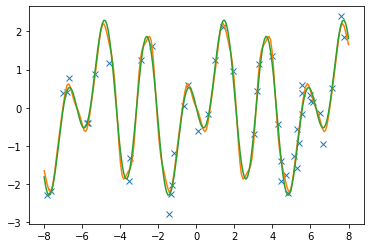

In [21]:
t = jnp.linspace(-8, 8, 200)
T = jnp.sin(np.matmul(t.reshape(-1, 1), 1+jnp.arange(p).reshape(1,p))).transpose()
plt.plot(x, y, 'x')
plt.plot(t, jnp.matmul(ap, T[:len(ap), :]))
plt.plot(t, jnp.matmul(a, T[:len(a), :]))
print('MSE: {}'.format(((y - Yp)**2).mean()))

In [22]:
p = 15
ap, Xp, Yp = sin_approx(x, y, p)
print(a, ap)

[ 0.7   0.83 -1.5 ] [ 0.35529602  1.1142317  -1.7437214   0.15871115  0.00858292 -0.10777945
  0.15600105 -0.08507273  0.08278456 -0.04437378  0.08144233 -0.01490425
 -0.21221659  0.28036714 -0.02712816]


MSE: 0.06189465522766113


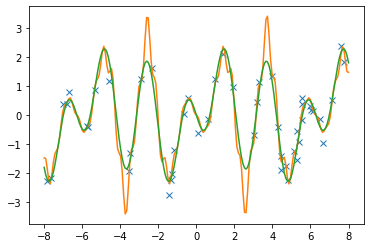

In [23]:
t = jnp.linspace(-8, 8, 200)
T = jnp.sin(np.matmul(t.reshape(-1, 1), 1+jnp.arange(p).reshape(1,p))).transpose()
plt.plot(x, y, 'x')
plt.plot(t, jnp.matmul(ap, T[:len(ap), :]))
plt.plot(t, jnp.matmul(a, T[:len(a), :]))
print('MSE: {}'.format(((y - Yp)**2).mean()))

In [24]:
p = 20
ap, Xp, Yp = sin_approx(x, y, p)
print(a, ap)

[ 0.7   0.83 -1.5 ] [-0.11323678  1.7993791  -2.3644838   0.49984902 -0.01194978 -0.32451046
  0.5129152  -0.50142884  0.45345783 -0.24447411  0.10667838  0.20195109
 -0.6100314   0.6498178  -0.25845143 -0.03708184  0.16033    -0.29417005
  0.03206168 -0.0902726 ]


MSE: 0.04660849645733833


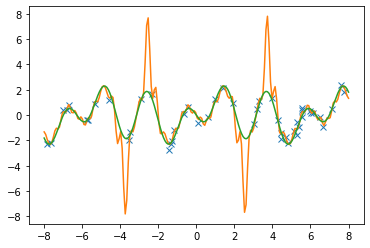

In [25]:
t = jnp.linspace(-8, 8, 200)
T = jnp.sin(np.matmul(t.reshape(-1, 1), 1+jnp.arange(p).reshape(1,p))).transpose()
plt.plot(x, y, 'x')
plt.plot(t, jnp.matmul(ap, T[:len(ap), :]))
plt.plot(t, jnp.matmul(a, T[:len(a), :]))
print('MSE: {}'.format(((y - Yp)**2).mean()))

In [26]:
p = 25
ap, Xp, Yp = sin_approx(x, y, p)
print(a, ap)

[ 0.7   0.83 -1.5 ] [ 2.483035   -1.9207842   0.57731056 -0.44159245 -0.9491972   1.4420291
 -1.1824136   0.8650079  -0.61695516  0.45492303  0.19773307 -1.0832504
  1.5003977  -1.1892037   0.3630464   0.81794167 -1.6101568   1.2754178
 -0.51291    -0.5356204   0.87538815 -0.7491144   0.10084951  0.21558303
 -0.11464696]


MSE: 0.0363682359457016


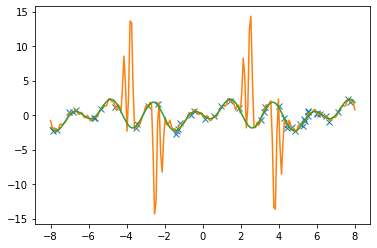

In [27]:
t = jnp.linspace(-8, 8, 200)
T = jnp.sin(np.matmul(t.reshape(-1, 1), 1+jnp.arange(p).reshape(1,p))).transpose()
plt.plot(x, y, 'x')
plt.plot(t, jnp.matmul(ap, T[:len(ap), :]))
plt.plot(t, jnp.matmul(a, T[:len(a), :]))
print('MSE: {}'.format(((y - Yp)**2).mean()))

In [28]:
p = 35
ap, Xp, Yp = sin_approx(x, y, p)
print(a, ap)

[ 0.7   0.83 -1.5 ] [-34.420845    53.54271    -47.404167    24.04839      2.5520477
 -22.580738    33.575417   -30.581444    22.487469    -8.539528
  -5.8411484   17.944695   -26.375664    26.720001   -15.869003
  -2.5119934   19.008682   -22.40055     14.070158    -1.2852402
  -7.173237     8.027071    -5.567108     0.89237213   2.7684917
  -2.0045357   -2.4827309    5.055525    -2.6962426   -2.1028605
   4.513747    -2.6814532   -0.19490051   0.98603344  -0.61041975]


MSE: 2.7143747806549072


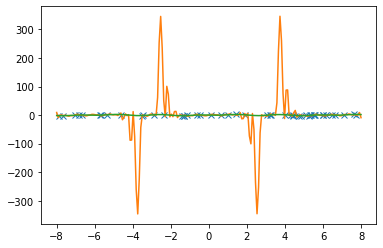

In [29]:
t = jnp.linspace(-8, 8, 200)
T = jnp.sin(np.matmul(t.reshape(-1, 1), 1+jnp.arange(p).reshape(1,p))).transpose()
plt.plot(x, y, 'x')
plt.plot(t, jnp.matmul(ap, T[:len(ap), :]))
plt.plot(t, jnp.matmul(a, T[:len(a), :]))
print('MSE: {}'.format(((y - Yp)**2).mean()))

## Train/validation

In [30]:
x_val = np.random.rand(48)*16-8
X_val = jnp.array([ jnp.sin(x_val), jnp.sin(2*x_val), jnp.sin(3*x_val)])
y_val = jnp.matmul(a, X_val) + 0.3*np.random.randn(48)

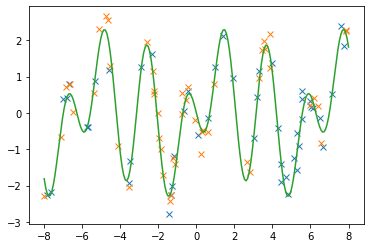

In [31]:
plt.plot(x, y, 'x')
plt.plot(x_val, y_val, 'x')
plt.plot(t, jnp.matmul(a, T[:len(a), :]))

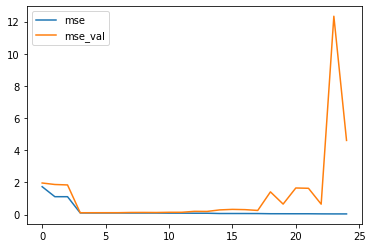

In [32]:
mse = []
mse_val = []
for p in range(25):
    ap, Xp, Yp = sin_approx(x, y, p)
    _, Xp_val, _ = sin_approx(x_val, y_val, p)
    Yp_val = jnp.matmul(ap, Xp_val)
    mse.append(((y - Yp)**2).mean()), mse_val.append(((y_val - Yp_val)**2).mean())
plt.plot(mse, label='mse'); plt.plot(mse_val, label='mse_val')
plt.legend()

# Regularization
Noisy observation:
$$ y = \mathbf{a}^\top\mathbf{x} + \varepsilon, \varepsilon \sim \mathcal{N}(0, \sigma)$$

Assume $\|\mathbf{a}\|_0 < d$ (not all input dimensions are used), can we force $\hat{\mathbf{a}}$ to be also sparse?

$$ \min_\mathbf{a} \mathbb{E}_x[(y - \mathbf{x}^\top\mathbf{a})^2] + \Omega(\mathbf{a}) $$

With $\Omega(\mathbf{a})$ a *regularizer* that increases cost for more complex $\mathbf{a}$

## LASSO
Least Absolute Shrinkage and Selection Operator

$$\min_\mathbf{a} \frac{1}{n}\sum_i (y_i - \mathbf{x}_i^\top\mathbf{a})^2 + \lambda\|\mathbf{a}\|_1 $$

Optimize using gradient descent

$$ \mathbf{a} \leftarrow \mathbf{a} - \eta \left[ \frac{-2}{n}\sum_i (y_i - \mathbf{x}_i^\top\mathbf{a}) + \lambda\text{sign}(\mathbf{a}) \right] $$


In [33]:
def sin_pred(a, X):
    return jnp.matmul(a, X)

def sin_lasso(a, X, y, lam):
    yp = sin_pred(a, X)
    return ((y - yp)**2).mean() + lam*jnp.abs(a).sum()

@jax.jit
def update(a, X, y, lam):
    da = jax.grad(sin_lasso, argnums=0)(a, X, y, lam)
    return a - 0.05*da

In [34]:
p=25
Xp = jnp.sin(jnp.matmul(x.reshape(-1, 1), 1+jnp.arange(p).reshape(1,p))).transpose()
ap = jnp.zeros(p)
for i in range(100):
    ap = update(ap, Xp, y, 0.1)
print(a, ap)

[ 0.7   0.83 -1.5 ] [ 6.5387887e-01  4.9198857e-01 -1.2269275e+00  1.6643824e-03
 -5.4124887e-03  2.7261022e-03 -4.6199327e-03  1.8823075e-03
 -1.3611598e-03  1.0498903e-01  6.7312829e-04 -6.6337660e-02
  1.5109220e-03  6.7850342e-03  6.5390445e-02 -2.7749939e-03
 -8.5329272e-02  3.3036065e-03 -6.3027009e-02 -5.3070008e-04
 -4.4770658e-04 -5.5702450e-03 -4.1388847e-02  4.2398345e-02
  5.0350791e-03]


MSE: 0.03701911121606827


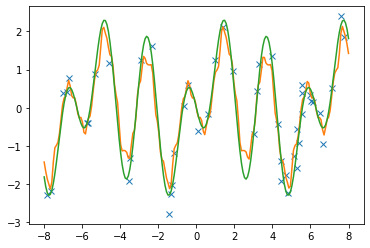

In [35]:
t = jnp.linspace(-8, 8, 200)
T = jnp.sin(np.matmul(t.reshape(-1, 1), 1+jnp.arange(p).reshape(1,p))).transpose()
plt.plot(x, y, 'x')
plt.plot(t, jnp.matmul(ap, T[:len(ap), :]))
plt.plot(t, jnp.matmul(a, T[:len(a), :]))
print('MSE: {}'.format(((y - Yp)**2).mean()))

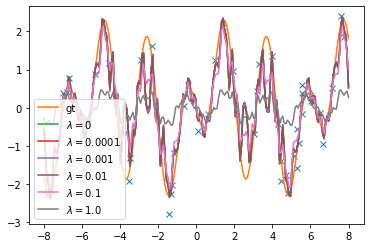

In [36]:
Xp = jnp.sin(jnp.matmul(x.reshape(-1, 1), 1+jnp.arange(p).reshape(1,p))).transpose()
plt.plot(x, y, 'x')
plt.plot(t, jnp.matmul(a, T[:len(a), :]), label='gt')
for lam in [0, 0.0001, 0.001, 0.01, 0.1, 1.0]:
    ap = jnp.zeros(p)
    for i in range(50):
        ap = update(ap, Xp, y, lam)
    plt.plot(t, jnp.matmul(ap, T[:len(ap), :]), label='$\lambda={}$'.format(lam))
plt.legend()

In [37]:
def lasso_approx(Xp, y, lam):
    ap = jnp.zeros(len(Xp[:,0]))
    for i in range(100):
        ap = update(ap, Xp, y, lam)
    Yp = jnp.matmul(ap, Xp)
    return ap, Xp, Yp 

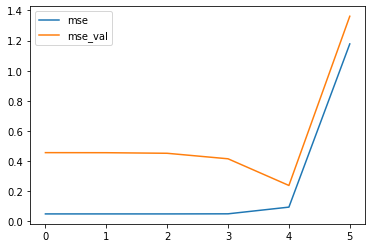

In [38]:
Xp = jnp.sin(jnp.matmul(x.reshape(-1, 1), 1+jnp.arange(p).reshape(1,p))).transpose()
Xp_val = jnp.sin(jnp.matmul(x_val.reshape(-1, 1), 1+jnp.arange(p).reshape(1,p))).transpose()
mse = []
mse_val = []
for lam in [0, 0.0001, 0.001, 0.01, 0.1, 1.0]:
    ap, Xp, Yp = lasso_approx(Xp, y, lam)
    Yp_val = jnp.matmul(ap, Xp_val)
    mse.append(((y - Yp)**2).mean()), mse_val.append(((y_val - Yp_val)**2).mean())
plt.plot(mse, label='mse'); plt.plot(mse_val, label='mse_val')
plt.legend()

## Analysis

Project $\mathbf{X}$ into its eigenspace:

$$ \min_\mathbf{a} \frac{1}{n} \|\mathbf{y} - \mathbf{X}^\top\mathbf{Ua}\|^2 + \lambda\|\mathbf{a}\|_1 $$
$$ =  \frac{1}{n} \|\mathbf{y} - \mathbf{VSa}\|^2 + \lambda\|\mathbf{a}\|_1$$

Stationary condition: 

$$\frac{\partial}{\partial \mathbf{a}}  = 0 = -2\mathbf{SV}^\top\mathbf{y} + 2\mathbf{S}^2\mathbf{a} + \lambda\text{sign}(\mathbf{a})$$
$$\mathbf{a} = \mathbf{S}^{-1}\mathbf{V}^\top\mathbf{y} - \mathbf{S}^{-2}\frac{\lambda\text{sign}(\mathbf{a})}{2}$$

Let $\tilde{\mathbf{a}} = \mathbf{S}^{-1}\mathbf{V}^\top\mathbf{y}$

Note that $\text{sign}(\mathbf{a}) = \text{sign}(\tilde{\mathbf{a}}) = \frac{\tilde{\mathbf{a}}}{\vert\tilde{\mathbf{a}}\vert}$
$$\mathbf{a} = \tilde{\mathbf{a}}\left(1 -  \frac{\lambda\mathbf{S}^{-2}}{2\vert\tilde{\mathbf{a}}\vert}\right)$$

Case $>0$,  $\text{sign}(\mathbf{a}) = \text{sign}(\tilde{\mathbf{a}}) = 1$

$$ \mathbf{a}_i = \color{blue}{\underbrace{\tilde{\mathbf{a}}_i}_{>0}} \left(1 -  \frac{\lambda\mathbf{S}^{-2}_i}{2\vert\tilde{\mathbf{a}}_i\vert}\right) >0$$

$$ \mathbf{a}_i = \tilde{\mathbf{a}}_i \max\left(0, 1 -  \frac{\lambda\mathbf{S}^{-2}_i}{2\vert\tilde{\mathbf{a}}_i\vert}\right) $$

Case $<0$,  $\text{sign}(\mathbf{a}) = \text{sign}(\tilde{\mathbf{a}}) = -1$

$$ \mathbf{a}_i = \color{blue}{\underbrace{\tilde{\mathbf{a}}_i}_{<0}} \left(1 -  \frac{\lambda\mathbf{S}^{-2}}{2\vert\tilde{\mathbf{a}}_i\vert}\right) <0$$

$$ \mathbf{a}_i = \tilde{\mathbf{a}}_i \max\left(0, 1 -  \frac{\lambda\mathbf{S}^{-2}}{2\vert\tilde{\mathbf{a}}_i\vert}\right) $$

Soft thresholding: 

$$ \mathbf{a} = \tilde{\mathbf{a}} \max\left(0, 1 -  \frac{\lambda\mathbf{S}^{-2}}{2\vert\tilde{\mathbf{a}}\vert}\right) $$

$\lambda$ removes components that would change the sign of the solution $\rightarrow$ Sparse solution

*Remember: analysis only valid in eigenspace*

## Conditioning

In eigenspace, pseudo-inverse solution:
$$ \mathbf{a} = \mathbf{US}^{-1}\mathbf{V}^\top\mathbf{y}$$

What if $\mathbf{S}$ has small eigenvalues ($\text{span}(\mathbf{X}) < d$)?
How to prevent solution to focus on the noise?

Avoid large values in the solution:

$$\min_\mathbf{a} \frac{1}{n}\sum_i (y_i - \mathbf{x}_i^\top\mathbf{a})^2 + \lambda\|\mathbf{a}\|^2 $$

Tikonov regularization (ridge regression)

## Analysis

$$\frac{1}{n} \|\mathbf{y} - \mathbf{X}^\top\mathbf{a}\|^2 + \lambda\|\mathbf{a}\|^2 $$


Stationary condition: 

$$\frac{\partial}{\partial \mathbf{a}} = 0 =\frac{2}{n}(\mathbf{X}^\top\mathbf{y} + \mathbf{XX}^\top\mathbf{a}) +2\lambda\mathbf{a} $$

$$\mathbf{a} = (\mathbf{XX}^\top +n\lambda\mathbf{I})^{-1}\mathbf{X}^\top\mathbf{y} $$

Offsetting all eigenvalues in the covariance matrix by $\lambda$

## Elastic net

Add both regularization

$$\min_\mathbf{a} \frac{1}{n}\sum_i (y_i - \mathbf{x}_i^\top\mathbf{a})^2 + \lambda_1\|\mathbf{a}\|_1 +\lambda_2\|\mathbf{a}\|_2^2$$

- $\lambda_1$ controls sparsity
- $\lambda_2$ controls sensitivity to noisy components

Optimize using gradient descent


# Other loss functions

$\ell_2$ is sensitive to outliers

1.0905238


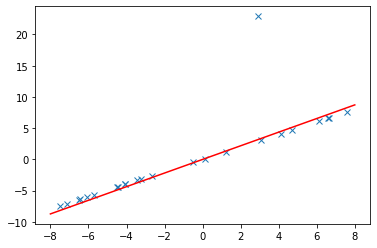

In [39]:
x = np.random.rand(24)*16-8
y = x + 0.1*np.random.rand(24)
y[0] += 20

a = jnp.dot(x, y)/jnp.dot(x, x)
print(a)
t = jnp.linspace(-8, 8, 10)
plt.plot(x, y, 'x')
plt.plot(t, a*t, '-r')

## MAE

Mean absolute error (or $\ell_1$ error)

$$\min_\mathbf{a} \mathbb{E}[ \vert y_i - \mathbf{a}^\top\mathbf{x}_i\vert ]$$

Vector case 

$$\min_\mathbf{a} \mathbb{E}[ \| \mathbf{y}_i - \mathbf{A}^\top\mathbf{x}_i\|_1 ]$$

No close form solution, gradient descent (subderivative $\nabla\|0\|_1 = 0$)

*robust* regression

0.974505


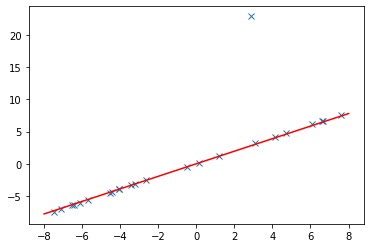

In [40]:
def l1(a, x, y):
    return jnp.abs(y - a*x).mean()

@jax.jit
def update(a, x, y):
    da = jax.grad(l1, argnums=0)(a, x, y)
    return a - 0.02*da

a = 0.
for i in range(100):
    a = update(a, x, y)
print(a)
t = jnp.linspace(-8, 8, 10)
plt.plot(x, y, 'x')
plt.plot(t, a*t, '-r')

# Sensitivity to small errors
- $\ell_2$: derivative falls quickly to zero
- $\ell_1$: constant derivative

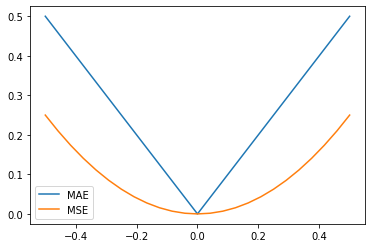

In [41]:
t = jnp.linspace(-0.5, 0.5, 25)
plt.plot(t, jnp.abs(t), label='MAE')
plt.plot(t, t**2, label='MSE')
plt.legend()

## Do both?

- Penalize large errors: $\ell_2$
- Penalize small errors (assuming no outliers): $\ell_1$

$$ \min_\mathbf{A} \mathbb{E}[ \|\mathbf{y} - \mathbf{A}^\top\mathbf{x}\|^2 + \lambda \|\mathbf{y} - \mathbf{A}^\top\mathbf{x}\|_1 ]$$

Optimize using gradient descent

## Full model
- Ridge regularization (noisy components)
- Sparsity regularization (overcomplete model)
- Large errors penalization
- Small errors penalization 

$$ \min_\mathbf{A} \mathbb{E}[ \|\mathbf{y} - \mathbf{A}^\top\mathbf{x}\|^2 + \lambda \|\mathbf{y} - \mathbf{A}^\top\mathbf{x}\|_1 ] + \lambda_2 \|\mathbf{A}\|_F^2 + \lambda_1 \|\mathbf{A}\|_1$$

- Optimize using gradient descent (surprise!)
- 3 hyper-parameters: use proper cross validation ("*With four parameters I can fit an elephant, and with five I can make him wiggle his trunk*", J. Von Neumann)

# Dictionary learning

Unsupervised learning: target space is a new representation of the input space

- Input: $\mathbf{X} \in \mathbb{R}^{d\times n}$
- Model: Dictionary $\mathbf{D} \in \mathbb{D}^{d\times p}$
- Output: Factors $\mathbf{A} \in \mathbb{R}^{p\times n}$

$$ \min_{\mathbf{D},\mathbf{A}} \|\mathbf{X} - \mathbf{DA}\|_F^2 $$

If $p < d$, then $\mathbf{D}$ are the $p$ leading left singular vectors of $\mathbf{X}$ and the factors $\mathbf{A}$ are the combination of the corresponding singular values with the right singular vectors

If $p > d$, we have an *overcomplete* dictionary, which means we can afford to not use all entries to reconstruct a sample

$$ \min_{\mathbf{a}} \|\mathbf{x} - \mathbf{Da}\|^2 +\lambda \|\mathbf{a}\|_0$$
Sparse coding





Alternate update:

- Fix $\mathbf{D}$, update $\mathbf{A}$

  - Difficult problem, relax to $\|\mathbf{a}\|_1$ or use iterative thresholding methods
  
- Fix $\mathbf{A}$, update $\mathbf{D}$

$$\mathbf{D} = \mathbf{X}(\mathbf{A}^\top\mathbf{A})^{-1}$$

## K-SVD

Update one atom at a time

- $\mathbf{d}_k$: atom $k$ of the dictionary
- $\mathbf{a}^k \in \mathbb{R}^n$: factors corresponding to atom $k$ 
- $\bar{\mathbf{D}}_k = [\mathbf{d}_i]_{i\neq k} \in \mathbb{R}^{d\times p-1}$: reduced dictionary without atom $\mathbf{d}_k$
- $\bar{\mathbf{A}}^k = [\mathbf{a}_i]_{i\neq k} \in \mathbb{R}^{p-1\times n}$: factors corresponding to the reduced dictionary

$$ \min_{\mathbf{D},\mathbf{A}} \|\mathbf{X} - \mathbf{DA}\|_F^2 = \|\mathbf{X} - \bar{\mathbf{D}}_k\bar{\mathbf{A}}^k - \mathbf{d}_k\mathbf{a}^k\|_F^2$$

$$ \mathbf{E}_k = \mathbf{X} - \bar{\mathbf{D}}_k\bar{\mathbf{A}}^k$$

Iterative updates: 
$$\min_{\mathbf{d}_k, \mathbf{a}^k} \|\mathbf{E}_k - \mathbf{d}_k\mathbf{a}^k\|_F^2$$

- SVD of $\mathbf{E}_k = \mathbf{USV}^\top$
- Rank 1 approximation: $\mathbf{E}_k \approx \mathbf{u}_1s_1\mathbf{v}_1^\top$
- Get hard thresholding selection matrix: $\Omega_k \in \{0, 1\}^{n\times n'}$, that select $n'$ samples that are coded by atom $k$ (ex: highest absolute values of $\mathbf{v}_1$)
- Compute reduced problem for selected samples:
$$\min_{\mathbf{d}_k, \mathbf{a}^k} \|\mathbf{E}\Omega_k - \mathbf{d}_k\mathbf{a}^k\Omega_k\|_F^2$$
- Update $\mathbf{d}_k$ and $\mathbf{a}^k$ using rank-1 approximation of $\mathbf{E}_k\Omega_k \approx \mathbf{u}s\mathbf{v}^\top$

In [43]:
X = jnp.transpose(data['X_train'])
y = data['y_train']

D = np.random.rand(784, 64)
A = np.random.rand(64, 100)

for e in range(50):
    D = jnp.matmul(jnp.matmul(X, A.T), jnp.linalg.inv(jnp.matmul(A, A.T)))
    A = jnp.matmul(jnp.linalg.inv(jnp.matmul(D.T, D)), jnp.matmul(D.T, X))
    S = jnp.sign(A)
    I = jnp.argsort(jnp.abs(A), axis=0)[-33, :]
    A = S * jnp.clip(jnp.abs(A) - jnp.abs(A[I, jnp.arange(100)]), a_min=0)

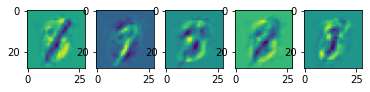

In [44]:
plt.subplot(1,5,1)
plt.imshow(D[:,0].reshape(28, 28))
plt.subplot(1,5,2)
plt.imshow(D[:,1].reshape(28, 28))
plt.subplot(1,5,3)
plt.imshow(D[:,2].reshape(28, 28))
plt.subplot(1,5,4)
plt.imshow(D[:,3].reshape(28, 28))
plt.subplot(1,5,5)
plt.imshow(D[:,4].reshape(28, 28))

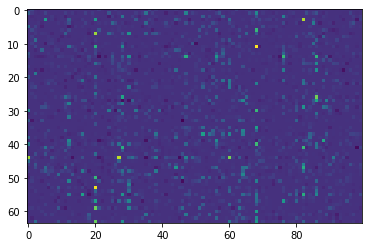

In [45]:
plt.imshow(A)

## MNIST

Exercise: Try a linear regression (vector output) using $\mathbf{A}$ instead of $\mathbf{X}$

## Why?

- $\mathbf{A}$ may provide a better alternative to $\mathbf{X}$ for doing learning a predictor
- $\mathbf{D}$ may provide insights (modes of $\mathbf{X}$)

Relation to k-means

$$ \min_{\mathbf{D},\mathbf{A}} \|\mathbf{X} - \mathbf{DA}\|_F^2\quad \text{ s.t.   } \forall i, \|\mathbf{a}_i\|_0 = 1$$
- Only a single atom selected per sample
- Alternate optimization:

$$\mathbf{d}_k = \frac{\mathbf{X}\mathbf{a}^{k\top}}{\|\mathbf{a}^k\|_1}$$
$$\mathbf{a}_i = [\mathbf{1}_{m=n}]_m, n = \text{argmin}_k\|\mathbf{d}_k - \mathbf{x}_i\|$$


# Linear Model (regression), take home

- MSE often leads to closed form solution
- MSE to penalize large errors, MAE to penalize small errors
- MAE robust to outliers

- Sensitivity to condition number: $\ell_2$ regularization
- Sparse model: $\ell_1$ regularization

- Dictionary learning

  - Find better representation with a linear model


- Non linear relation: explicit non-linear mapping + linear model